### Проверка гипотез

In [138]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import*
import scipy
path = 'C:/Users/luzhbin.aleksey/Desktop/data analysis/Выгрузки/Oper_0103_1704.txt'

**Функции обработки данных:**

In [185]:
def Zm_mean(df):
    massiv = []
    for i in sorted(set(df.Date)):
        massiv.append((i, np.mean(df.Sum[df.Date == i].values)))
    return massiv

In [186]:
def shapiro(product):
    zm = Zm_mean(data[data.NameProduct == product])
    x = list(map(lambda x: x[1], zm))

    plt.hist(x, bins = 10, rwidth = 0.8)
    plt.grid(axis = 'y')

    print('length: {}'.format(len(x)))
    print('min: {:.1f}, max: {:.1f}, median: {:.1f}, std: {:.1f}'.format(np.min(x), np.max(x), np.median(x), np.std(x)))
    print('The Shapiro-Wilk test statistic: {:.4f}\np-value: {:.6f}'.format(stats.shapiro(x)[0], stats.shapiro(x)[1]))

In [202]:
def student(product, m):
    zm0 = Zm_mean(data[data.NameProduct == product[0]])
    zm1 = Zm_mean(data[data.NameProduct == product[1]])
    x0 = list(map(lambda x: x[1], zm0))
    x1 = list(map(lambda x: x[1], zm1))
    if m == 'ind': t = scipy.stats.ttest_ind(x0, x1)
    else: t = scipy.stats.ttest_rel(x0, x1)
    print('The t-statistic: {:.4f}\np-value: {:.10f}'.format(t[0], t[1]))

In [188]:
def boxes(num):
    f = np.unique(data.NameProduct.values, return_counts = True)
    f = set(f[0][f[1] > num])

    product = set(data.TypeProduct)
    empty = set()
    for i in product:
        if (set(data.NameProduct[data.TypeProduct == i]) & f) == set():
            empty.add(i)
    notempty = product - empty

    s = np.unique(data.TypeProduct.values, return_counts = True)
    s = sorted(zip(s[0], s[1]), key = lambda x: x[1], reverse = True)
    s = [s[i][0] for i in range(len(s)) if s[i][0] in notempty]

    fliers_nums = []
    fliers_names = []
    fig, axes = plt.subplots(1, min([len(s), 4]), figsize = (20, 5))
    for i, ax in zip(s, axes.flatten()):
        x = []
        y = []
        for j in set(data.NameProduct[data.TypeProduct == i]) & f:
            d = data[data.NameProduct == j]
            zm = Zm_mean(d)
            y.append(list(map(lambda x: x[1], zm)))
            x.append(j)
        boxes = ax.boxplot(y)
        ax.set_xticklabels(list(map(lambda x: x[:10] + '...', x)), fontsize = 14, rotation = 90)
        ax.set_title('Распределение: {}'.format(i), fontsize = 14)
        ax.grid(axis = 'y')
        fliers_nums.append(list(map(lambda x: x.get_data()[1], boxes['fliers'])))
        fliers_names.append(x)
    plt.show()
    return [list(zip(fliers_names[i], fliers_nums[i])) for i in range(len(fliers_nums))]

**Использована выгрузка по операциям за период 01.03.2019 - 17.04.2019:**

In [189]:
data = pd.read_csv(path, sep = '\t', dtype = {'Sum': 'float'})
data = data[['Vid', 'Client', 'Dog', 'TypeProduct', 'NameProduct', 'Sum', 'DataVipolneniya', 'OrganizVid']]
data = data[(data.Vid == 'Выдача займа') & (data.TypeProduct != 'auto-lombard')]

s = []
col = list(data.columns).index('DataVipolneniya')
for i in range(data.shape[0]):
    s.append(dt.datetime.strptime(data.iloc[i, col].split(' ')[0], "%d.%m.%Y"))
data['Date'] = s
data.drop(columns = ['DataVipolneniya'], axis = 1, inplace = True)

**"Ящики с усами" визуализируют распределение среднедневных значений займов в срезе продуктов и каналов продаж:**

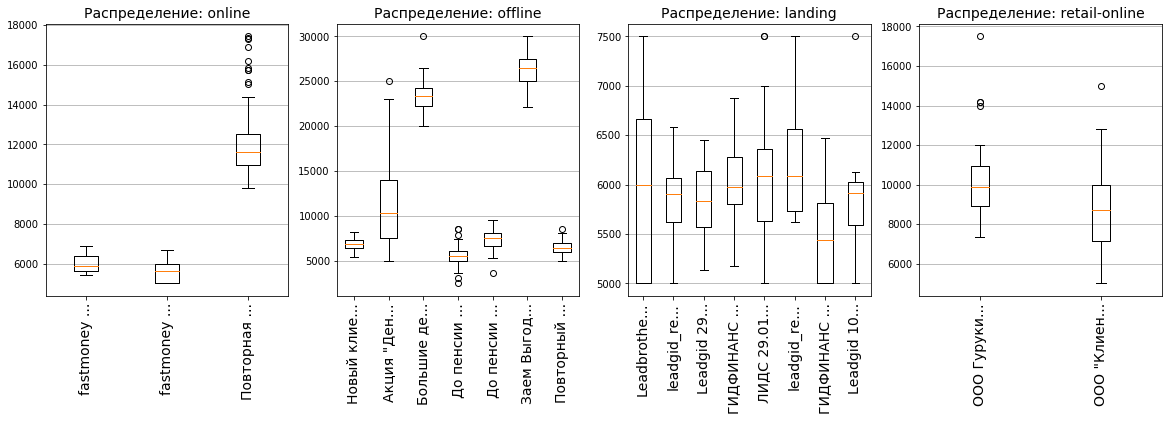

In [190]:
fliers = boxes(100)

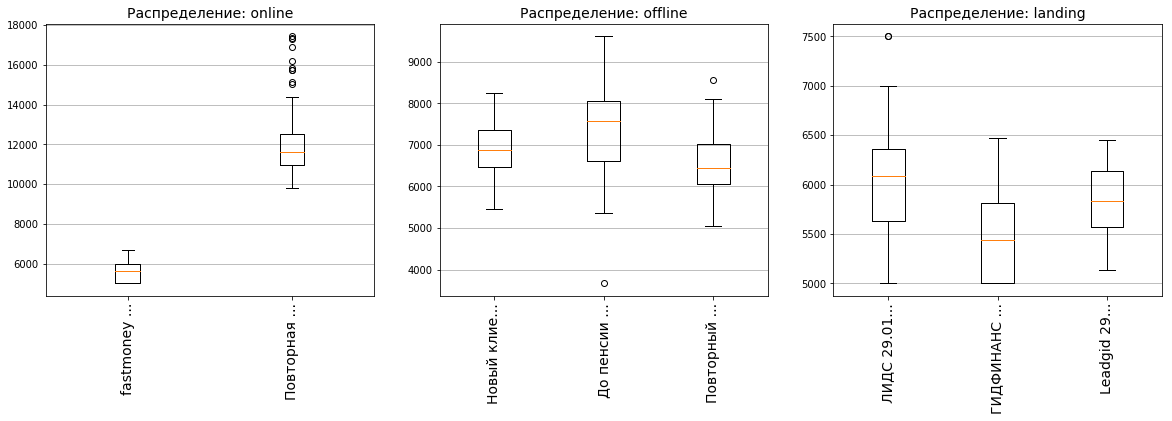

In [191]:
fliers = boxes(500)

**Нам нужны те распределения, которые похожи на нормальные. Выберем такие сначала "на глаз", а потом проверим их нормальность с помощью теста:**

length: 48
min: 5445.7, max: 8244.4, median: 6888.7, std: 620.9
The Shapiro-Wilk test statistic: 0.9836
p-value: 0.733991


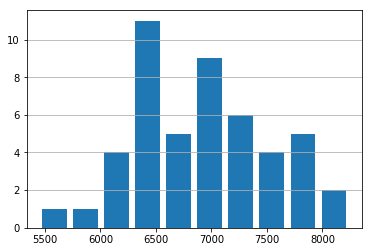

In [192]:
shapiro('Новый клиент от 29.01.2019')

length: 48
min: 5037.0, max: 8550.0, median: 6436.7, std: 763.2
The Shapiro-Wilk test statistic: 0.9827
p-value: 0.693206


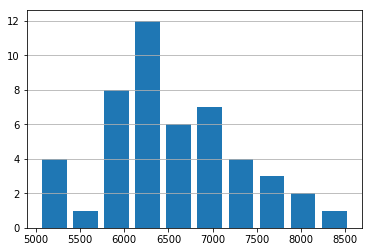

In [193]:
shapiro('Повторный от 29.01.2019')

length: 48
min: 5000.0, max: 7500.0, median: 6090.9, std: 573.9
The Shapiro-Wilk test statistic: 0.9692
p-value: 0.235814


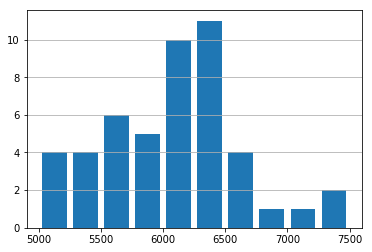

In [194]:
shapiro('ЛИДС 29.01.2019')

**Все выбранные распределения прошли тест на нормальность. Проверим гипотезу о равенстве средних на двух парах выбранных распределений (гипотеза о равенстве типичных представителей двух зависимых / независимых популяций):**

In [203]:
student(['Новый клиент от 29.01.2019', 'Повторный от 29.01.2019'], 'rel')

The t-statistic: 2.8387
p-value: 0.0066694732


In [204]:
student(['Новый клиент от 29.01.2019', 'ЛИДС 29.01.2019'], 'ind')

The t-statistic: 7.1601
p-value: 0.0000000002


**Обе гипотезы не подтвердились и могут быть отклонены.**

**Вывод: новые и повторные заемщики из *offline*, заемщики из *offline* и *landing* - это, вероятнее всего, различные популяции, т.е. клиенты с разными целями, потребностями, склонностью к риску и т.п.; могут быть отсегментированы в части принятия решений и предлагаемых условий.**